# DS5

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import geopy
import folium

## Prep

In [57]:
dtf = pd.read_csv("./directory.csv")
dtf = dtf[dtf["City"] == 'Las Vegas']
dtf = dtf[["City", 'Street Address', 'Longitude', 'Latitude']]
dtf.head()

,City,Street Address,Longitude,Latitude
20644,Las Vegas,4507 Flamingo Rd,-115.20,36.12
20645,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
20646,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
20647,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
20648,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


## Der neun columns

In [58]:
dtf['Potential'] = np.random.randint(low=3, high=11, size=len(dtf))
dtf['Staff'] = dtf['Potential'].apply(lambda x: int(np.random.rand()*x)+1)
dtf['Capacity'] = dtf['Potential'] - dtf['Staff']
dtf["cost"] = np.random.choice (['high', 'medium', 'low'], size=len(dtf), p=[0.4, 0.5, 0.1])
dtf.head()

,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,cost
20644,Las Vegas,4507 Flamingo Rd,-115.20,36.12,7,4,3,high
20645,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,4,4,0,high
20646,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,7,2,5,medium
20647,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,6,6,0,medium
20648,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,8,6,2,high


## Lat & Lnt

In [59]:
city = 'Las Vegas'
locator = geopy.geocoders.Nominatim(user_agent= 'MyCoder')
location = locator.geocode(city)
print(location)

Las Vegas, Clark County, Nevada, United States


In [60]:
location = [location.latitude, location.longitude]
print('[lat, long]: ', location)

[lat, long]:  [36.1672559, -115.148516]


In [61]:
colours = []
for i in dtf['cost']:
    if i=='high': colours.append('red')
    if i=='medium': colours.append('orange')
    if i=='low': colours.append('green')

dtf['Colour'] = colours
dtf.head()

,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,cost,Colour
20644,Las Vegas,4507 Flamingo Rd,-115.20,36.12,7,4,3,high,red
20645,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,4,4,0,high,red
20646,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,7,2,5,medium,orange
20647,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,6,6,0,medium,orange
20648,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,8,6,2,high,red


## Map man

In [62]:
map_ = folium.Map(location=location, tiles='cartodb positron')
dtf.apply(lambda row: folium.CircleMarker(
           location=[row["Latitude"],row["Longitude"]], popup=row["Street Address"],
           color=row["Colour"], fill=True,
           radius=row["Staff"]).add_to(map_), axis=1)
map_

# T12 -Da b0ne z0ne-

In [70]:
from sklearn.cluster import DBSCAN

xXx  = dtf[['Latitude','Longitude']]
dbs1 = DBSCAN(eps=0.025, min_samples=3).fit(xXx)
labels_dbs1 = dbs1.labels_
print(labels_dbs1)
dtf['dbs1'] = dbs1

[ 0  0  0  1  0  0  0  2  3  1  0  0  1  0  1  0  0  1  0  0  1  0  1  0
  1  1  1  0  0  1  1 -1  0 -1  0  0  0  1  0  1  0  1  0  0 -1  0  1  0
  0 -1  0  1  2  0  1  1  0  0  0  0  0  3  1  0  1  0  1  0  1 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  3  0 -1  1  1  1  1  0  0  0  0  0  0 -1
  0  1  0  0  0  0  3  0  0  1  1  0 -1  2  1  1  0  1  0  0  0  0  1  1
  0  0  0  0  0  0  0  1  1  0  0  0 -1  0  0  0  0  2  0  0  0  1  2  0
  1  0 -1  1 -1  1  0  0  1  1  0  1]


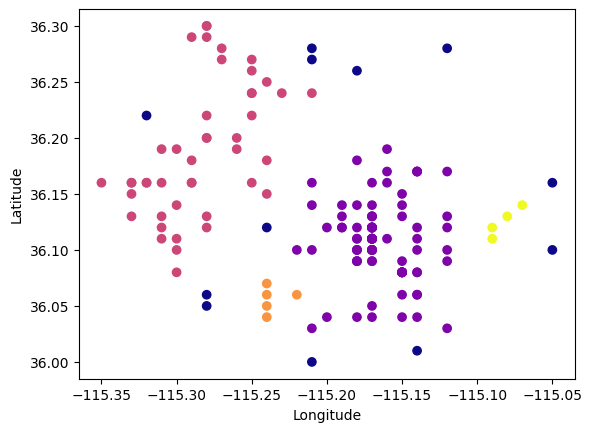

In [67]:
plt.scatter(xXx['Longitude'], xXx['Latitude'], c=labels_dbs1, cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [74]:
# Defineatley not stolen code
dtf_new = pd.DataFrame()
for c in sorted(dtf['dbs1'].unique()):
    dtf_cluster = dtf[dtf['dbs1']==c]
    
    ## hubs and targets
    lst_hubs = dtf_cluster[dtf_cluster["cost"]=="low"
               ].sort_values("Capacity").to_dict("records")
    lst_targets = dtf_cluster[dtf_cluster["cost"]=="high"
               ].sort_values("Staff").to_dict("records")
    ## move targets
    for target in lst_targets:
         for hub in lst_hubs:
             ### if hub has space
             if hub["Capacity"] > 0:
                residuals = hub["Capacity"] - target["Staff"]
                #### case of hub has still capacity: do next target
                if residuals >= 0:
                   hub["Staff"] += target["Staff"]
                   hub["Capacity"] = hub["Potential"] - hub["Staff"]
                   target["Capacity"] = target["Potential"]
                   target["Staff"] = 0
                   break
                #### case of hub is full: do next hub
                else:
                   hub["Capacity"] = 0
                   hub["Staff"] = hub["Potential"]
                   target["Staff"] = -residuals
                   target["Capacity"] = target["Potential"]-target["Staff"]
    dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
                 ).append(pd.DataFrame(lst_targets))
dtf_new = dtf_new.append(dtf[dtf["cost"]=="medium"]
                 ).reset_index(drop=True).sort_values(
                 ['dbs1',"Staff"])
dtf_new.head()

C:\Users\Petint\AppData\Local\Temp\ipykernel_16064\4206350352.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
C:\Users\Petint\AppData\Local\Temp\ipykernel_16064\4206350352.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
C:\Users\Petint\AppData\Local\Temp\ipykernel_16064\4206350352.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_new = dtf_new.append(dtf[dtf["cost"]=="medium"]


,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,cost,Colour,dbs1
19,Las Vegas,1940 Village Center Cir,-115.31,36.19,5,0,5,high,red,"DBSCAN(eps=0.025, min_samples=3)"
20,Las Vegas,"4916 S. Ft. Apache Road, #1A",-115.30,36.10,3,0,3,high,red,"DBSCAN(eps=0.025, min_samples=3)"
21,Las Vegas,5757 Paradise Rd.,-115.14,36.06,4,0,4,high,red,"DBSCAN(eps=0.025, min_samples=3)"
22,Las Vegas,"751 N. Rancho Drive, #110",-115.18,36.18,3,0,3,high,red,"DBSCAN(eps=0.025, min_samples=3)"
23,Las Vegas,3010 W Ann Rd,-115.18,36.26,4,0,4,high,red,"DBSCAN(eps=0.025, min_samples=3)"
